# Autocorrelation
---
Here we treat a perfect pupil with no leakage
---

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
from lib.FT_modelling import *
from lib.formatter import * 
from lib.conversions import *

In [4]:
pupil = pupil_from_fits("pupil.fits")
print(pupil.shape)

(4000, 4000)


---
Method:
 - Generate a perfect PSF on a 2N sized grid, allowing the PSF to be centered on the corner pixels without array errors
 - Generate a series of random stellar positons and fluxes and generate an image with these stellar PSFs
 - Autocorrelate the perfect PSF

In [5]:
# Define simulation parameters

aperture = 0.018 # 18mm
m2_obsc = 0 # m
wl = 525e-9 # 525nm - Central green band on RBP cam
focal_length = 0.15 # 15cm camera lens
chip_dim = 512 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
transform_size = 2**10 # 1024
x = 0 # On-axis star (pixel units)
y = 0 # On-axis star (pixel units)

In [6]:
# Padding parameters
size_PSF = int(focal_length * np.tan(10*wl/aperture)/pix_size)
pad_pix = size_PSF + 5
sub_c = chip_dim+2*pad_pix # Center pixel value for subtraction image

print("Padding size: {}".format(pad_pix))

Padding size: 44


## Create the perfect PSFs

In [7]:
%%time 
# Create convolution PSF
conv_PSF = FT_model(pupil, aperture, m2_obsc, chip_dim + 2*pad_pix, wl, focal_length, pix_size, 2*transform_size, x, y) # Convolution PSF

# Create subtraction PSF (twice the size so the PSF can be placed in the corners with masking)
sub_PSF = FT_model(pupil, aperture, m2_obsc, 2*chip_dim, wl, focal_length, pix_size, 2*transform_size, x, y) # Subraction PSF

CPU times: user 1.81 s, sys: 328 ms, total: 2.14 s
Wall time: 2.25 s


conv_PSF shape: (600, 600)
sub_PSF shape: (1024, 1024)


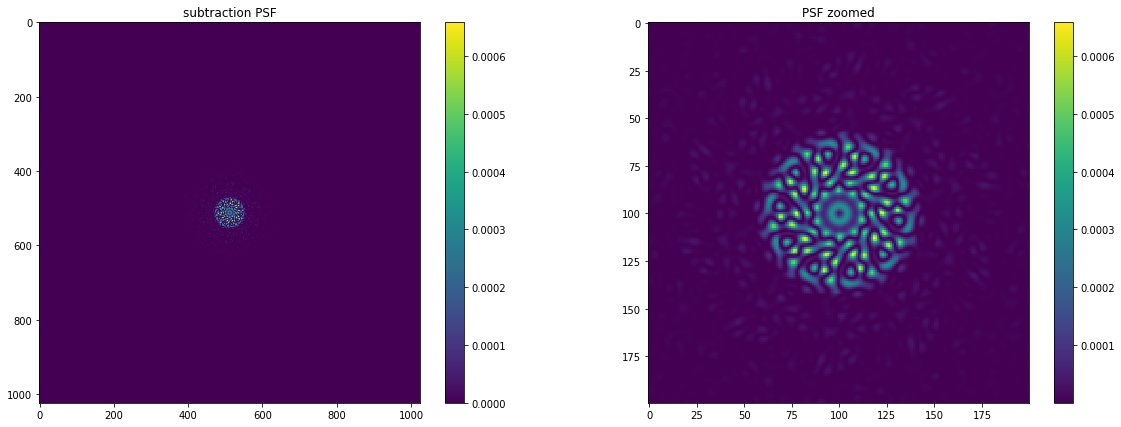

In [12]:
print("conv_PSF shape: {}".format(conv_PSF.shape))
print("sub_PSF shape: {}".format(sub_PSF.shape))

s = 100
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(sub_PSF)
plt.title("subtraction PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(sub_PSF[chip_dim-s:chip_dim+s, chip_dim-s:chip_dim+s])
plt.title("PSF zoomed")
plt.colorbar()
plt.show()

## Auto-correlate the PSF

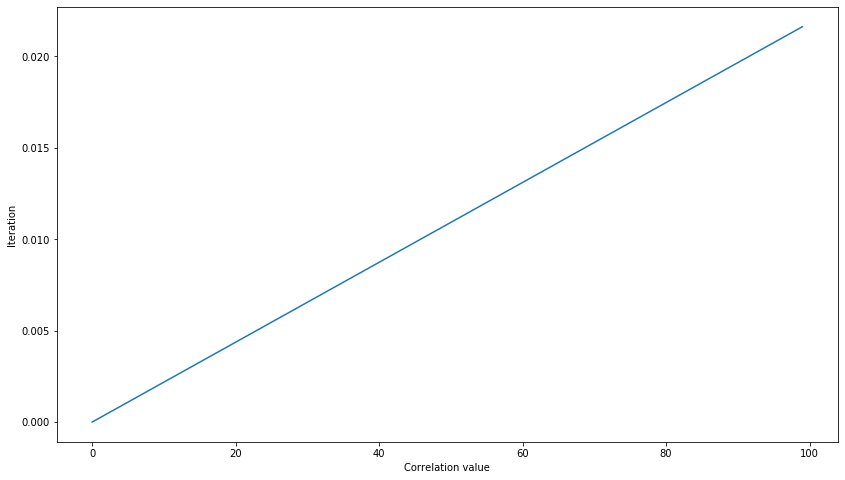

In [13]:
# Cut down the size to the detector
s = chip_dim//2
auto_PSF = sub_PSF[chip_dim-s:chip_dim+s, chip_dim-s:chip_dim+s]

peaks = []
for i in range(100):
#     auto_PSF_scale = multi*i*auto_PSF
    auto_PSF_scale = i*auto_PSF
    val = np.multiply(np.fft.fft2(auto_PSF), np.fft.fft2(auto_PSF_scale))
    auto_corr = np.real(np.fft.fftshift(np.fft.ifft2(val)))
    peaks.append(np.max(auto_corr))


# # Transform padded data image and convolution PSF
# fft_PSF = np.square(np.fft.fft2(auto_PSF))
# fft_im = np.fft.fft2(im_pad)
# # Element wise multiplication in Fourier space
# mult = np.multiply(fft_PSF, fft_im)
# # Inverse FFT to return autocorrelation


# plt.figure(figsize=(10,10))
# plt.imshow(auto_corr)
# plt.colorbar()
# plt.show()

plt.figure(figsize=(14,8))
plt.plot(peaks)
plt.xlabel("Correlation value")
plt.ylabel("Iteration")
plt.show()

This demonstrates a clear linear relationship between the value of the correalted PSF and the correlation PSF.

This means that we can find the relationship between the number of photons in the PSF and the correlation value

In [10]:
scale = 1e6
auto_PSF_scale = scale*auto_PSF
val = np.multiply(np.fft.fft2(auto_PSF), np.fft.fft2(auto_PSF_scale))
auto_corr = np.real(np.fft.fftshift(np.fft.ifft2(val)))
peak = np.max(auto_corr)
scaling = scale/peak
print(scaling)

4577.46022015055


We can now use this value to mutliply by our correlation value to find the approximate photon count for each PSF

---

## Simulate field of stars

In [25]:
# Define image paramters

n_stars = 1
min_flux = 1e4
max_flux = 1e6

# np.random.seed(0)
# np.random.seed(1)
# np.random.seed(2)
# np.random.seed(3)
# np.random.seed(4)
np.random.seed(5) # interesting
# np.random.seed(6)
# Generate a list of x-y coordinates in range (-chip_dim/2, chip_dim/2) as our stellar postions
# Seeded for reporducability
pixel_idx = (chip_dim - 2*pad_pix)*(np.random.rand(2*n_stars)).reshape([n_stars, 2]) 
positions = (chip_dim - 2*pad_pix)*(np.random.rand(2*n_stars) - 0.5).reshape([n_stars, 2])
positions = positions.astype(np.int)

# Generate a list of stellar fluxes (photons) between the min and max flux values
# Again seeded for reporducability
fluxes = min_flux + (max_flux-min_flux)*np.random.rand(n_stars)

In [26]:
print(positions)

[[-124  177]]


In [27]:
# Generate detector (gaussian) noise
# mean = 50
# stdev = 5
mean = 0
stdev = 0
noise = np.random.normal(loc=mean, scale=stdev, size=[chip_dim, chip_dim])

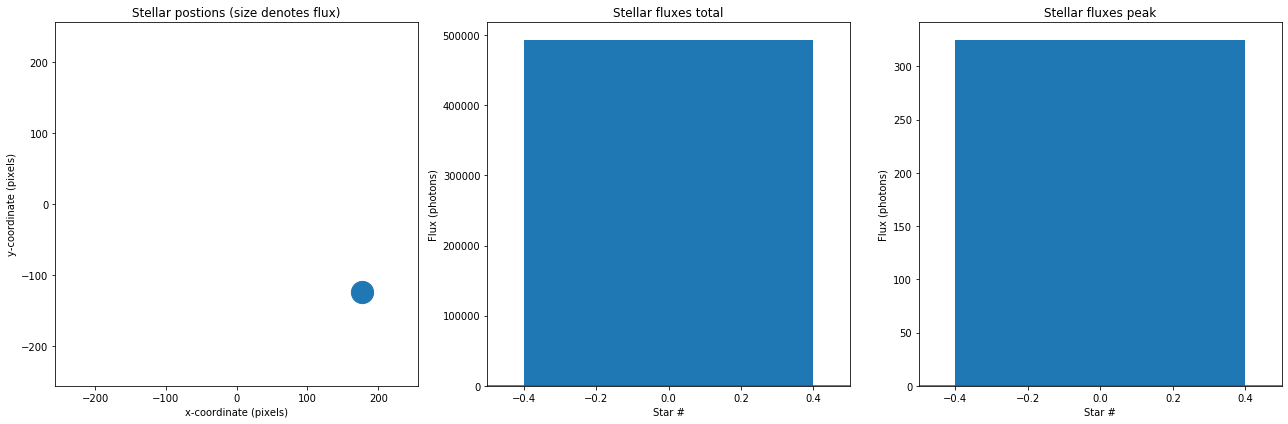

In [36]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Stellar postions (size denotes flux)")
plt.scatter(positions[:,1], positions[:,0], s=fluxes/1000)
plt.xlim(-chip_dim//2, chip_dim//2)
plt.ylim(-chip_dim//2, chip_dim//2)
plt.xlabel("x-coordinate (pixels)")
plt.ylabel("y-coordinate (pixels)")

plt.subplot(1,3,2)
plt.title("Stellar fluxes total")
plt.bar(range(n_stars), fluxes)
plt.xlabel("Star #")
plt.ylabel("Flux (photons)")
plt.plot(range(-1, n_stars+1), mean*np.ones(n_stars+2), color='r')
plt.xlim(-.5, n_stars-.5)

plt.subplot(1,3,3)
plt.title("Stellar fluxes peak")
plt.bar(range(n_stars), fluxes*np.max(sub_PSF))
plt.xlabel("Star #")
plt.ylabel("Flux (photons)")
plt.plot(range(-1, n_stars+1), mean*np.ones(n_stars+2), color='r')
plt.xlim(-.5, n_stars-.5)

plt.tight_layout()
plt.show()

---
Generate the data image, pure PSFs

In [37]:
# %%time

# Create simulate and sum the different stellar positions and fluxes
im_orig = np.zeros([chip_dim, chip_dim]) + noise
for i in range(n_stars):
    im_orig += fluxes[i]*FT_model(pupil, aperture, m2_obsc, chip_dim, wl, focal_length, pix_size, 
                             transform_size, positions[i, 1], positions[i, 0], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(im_orig)

# Pad image array for convolution
im_pad_orig = np.empty([chip_dim + 2*pad_pix, chip_dim + 2*pad_pix,])
im_pad_orig[pad_pix:chip_dim+pad_pix, pad_pix:chip_dim+pad_pix] = im
# Keep a copy of the original padded image so we can work on the "im_pad" variable
im_pad = deepcopy(im_pad_orig)

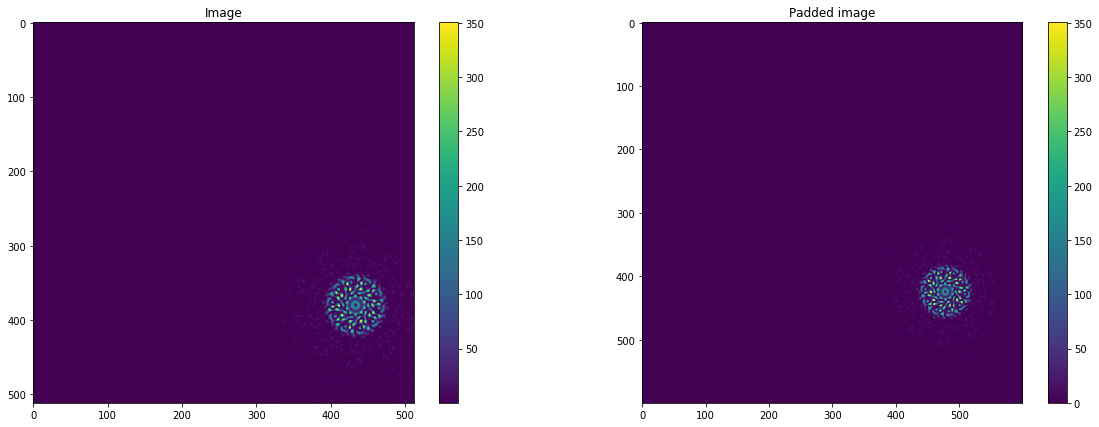

In [38]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(im)
plt.title("Image")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(im_pad)
plt.title("Padded image")
plt.colorbar()

plt.show()

---

## Convolution theorem: 


Cross-correlation of two images is $F^{-1}(F(f) * F(g))$

where * is an element wise multiplication and $F$ and $F^{-1}$ are the Fourier transform and inverse Fourier tranform respecitvely

In [39]:
# Transform padded data image and convolution PSF, element-wise multiplicationand inverse FFT
fft_PSF = np.fft.fft2(conv_PSF)
fft_im = np.fft.fft2(im_pad)
mult = np.multiply(fft_PSF, fft_im)
conv = np.fft.fftshift(np.fft.ifft2(mult))

# Take real component to get correation
correlation = np.real(conv)

# Get index of peak correlation point and convert back to a position
idx = np.array(np.where(correlation == np.max(correlation))).reshape(2)
pos = np.array([ idx[1] - (pad_pix + chip_dim//2), (pad_pix + chip_dim//2) - idx[0] ])

Imaginary component seems to how no information (and magnitude array is identical to real array)

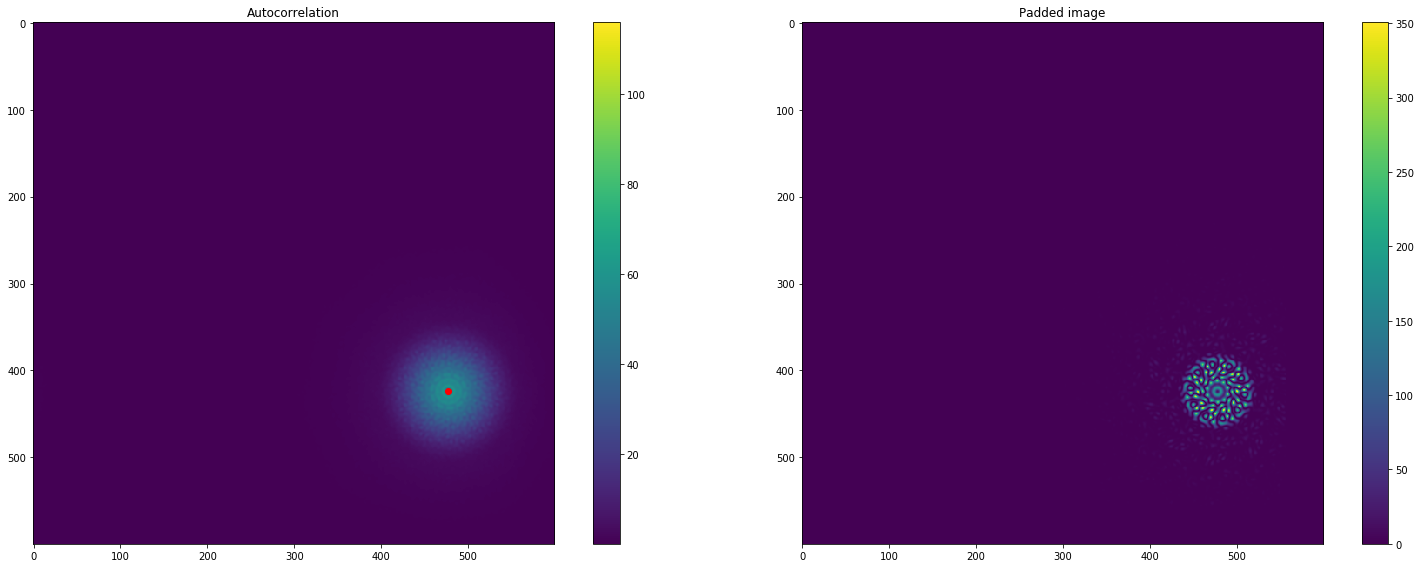

In [40]:
plt.figure(figsize=(22,8))

plt.subplot(1, 2, 1)
plt.imshow(correlation)
plt.colorbar()
plt.title("Autocorrelation")
plt.scatter(idx[1], idx[0], color='r')

plt.subplot(1, 2, 2)
plt.imshow(im_pad)
plt.colorbar()
plt.title("Padded image")

plt.tight_layout()
plt.show()

---
Begin image subraction

In [45]:
%%time

i = 0
fft_PSF = np.fft.fft2(conv_PSF)
im = deepcopy(im_orig)
positions_out = []
fluxes_out = []
max_i = []
min_i = []
max_corr = []

# while np.max(im) > 100:# and np.min(im) > -100:    
while True:
    # Pad the array from the image
    im_pad[pad_pix:chip_dim+pad_pix, pad_pix:chip_dim+pad_pix] = im
    
    # Autocorrelate the padded image
    fft_im = np.fft.fft2(im_pad)
    mult = np.multiply(fft_PSF, fft_im)
    conv = np.fft.fftshift(np.fft.ifft2(mult))
    correlation = np.real(conv)[pad_pix:-pad_pix, pad_pix:-pad_pix]
    
    # Find position with the greatest correlation value
    maxes = np.where(correlation == np.max(correlation))
    idx = np.array(maxes).reshape(2) 
    pos = np.array([idx[1]-(chip_dim//2), (chip_dim//2)-idx[0]])

    # Find the approximate flux using the correlation value
    flux = scaling*correlation[idx[0], idx[1]] 
    
    # Contrstucuct a mask to center the subtraction PSF on the image PSF
    sub_PSF_masked = sub_PSF[chip_dim - idx[0]: 2*chip_dim - idx[0], chip_dim - idx[1]: 2*chip_dim - idx[1]]

    # Subtract the PSF from the image scaled by 5% of the correlation flux value
    im -= 0.05*flux*sub_PSF_masked
    
    # Add the subracted flux to the list
    positions_out.append((pos[0], pos[1]))
    fluxes_out.append(0.05*flux)
    
    # Track the min and max values over time
    max_i.append(np.max(im))
    min_i.append(np.min(im))
    max_corr.append(np.max(correlation))
        
    # Termination condition
    if i != 0 and (max_corr[i-1] - max_corr[i]) < 0.009: # This is the threshold at which is stars picking up non-stellar points
        break
#     if np.max(im) <= 1.5*np.max(noise):
#         break
        
    # Iterate
    i += 1

print(i)
positions_out = np.array(positions_out)
fluxes_out = np.array(fluxes_out)

131
CPU times: user 3.65 s, sys: 311 ms, total: 3.96 s
Wall time: 4.9 s


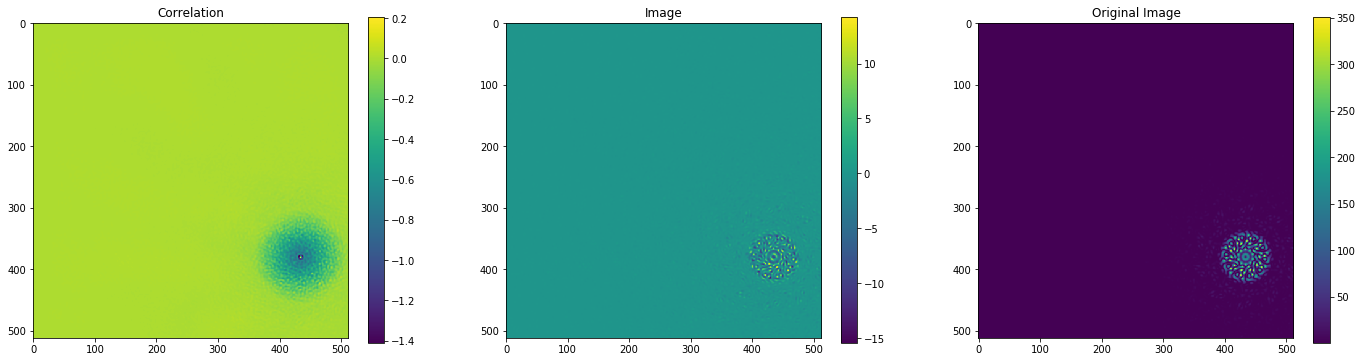

In [46]:
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.imshow(correlation)
plt.title("Correlation")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(im)
plt.title("Image")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(im_orig)
plt.title("Original Image")
plt.colorbar()

plt.show()

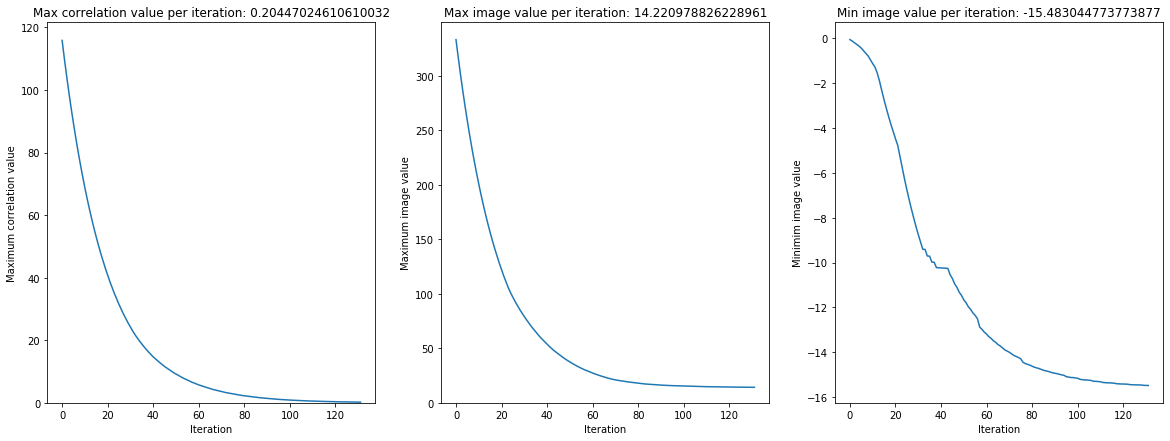

In [47]:
plt.figure(figsize=(20,7))

plt.subplot(1, 3, 1)
plt.plot(max_corr)
plt.xlabel("Iteration")
plt.ylabel("Maximum correlation value")
plt.title("Max correlation value per iteration: {}".format(max_corr[-1]))
plt.ylim(bottom=0)


plt.subplot(1, 3, 2)
plt.plot(max_i)
plt.xlabel("Iteration")
plt.ylabel("Maximum image value")
plt.title("Max image value per iteration: {}".format(max_i[-1]))
plt.ylim(bottom=0)

plt.subplot(1, 3, 3)
plt.plot(min_i)
plt.xlabel("Iteration")
plt.ylabel("Minimim image value")
plt.title("Min image value per iteration: {}".format(min_i[-1]))
if np.min(min_i) >= 0:
    plt.ylim(bottom=0)

plt.show()

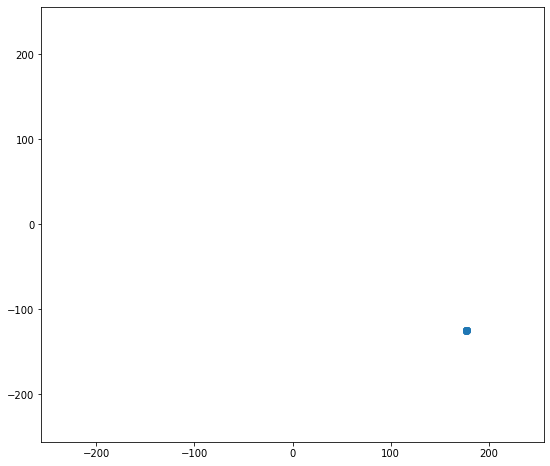

In [48]:
plt.figure(figsize=(9,8))
plt.scatter(positions_out[:,0], positions_out[:,1], alpha=0.1)
plt.xlim(-chip_dim//2, chip_dim//2)
plt.ylim(-chip_dim//2, chip_dim//2)
plt.show()

In [49]:
uni = np.unique(positions_out, axis=0)
# print(np.sort(uni))
print(len(uni))

4


In [50]:
total_fluxes = []
for i in range(len(uni)):
    mask = positions_out == uni[i]
    masked_flux = fluxes_out[mask[:,0]]
    total_fluxes.append(np.sum(masked_flux))

In [51]:
flux_found = np.zeros(len(positions)) # Combined fluxes
pos_found = []
tol = 3
for i in range(len(positions)):
    realx = positions[i][0]
    realy = positions[i][1]
    found = False
    
    for j in range(len(uni)):
        foundx = uni[j][1] 
        foundy = uni[j][0]
        
        if foundx >= realx-3 and foundx <= realx+3 and foundy >= realy-3 and foundy <= realy+3:
            found = True
            flux_found[i] = fluxes_out[j]
            
    if found == True:
        pos_found.append(positions[i])
        
pos_found = np.array(pos_found)

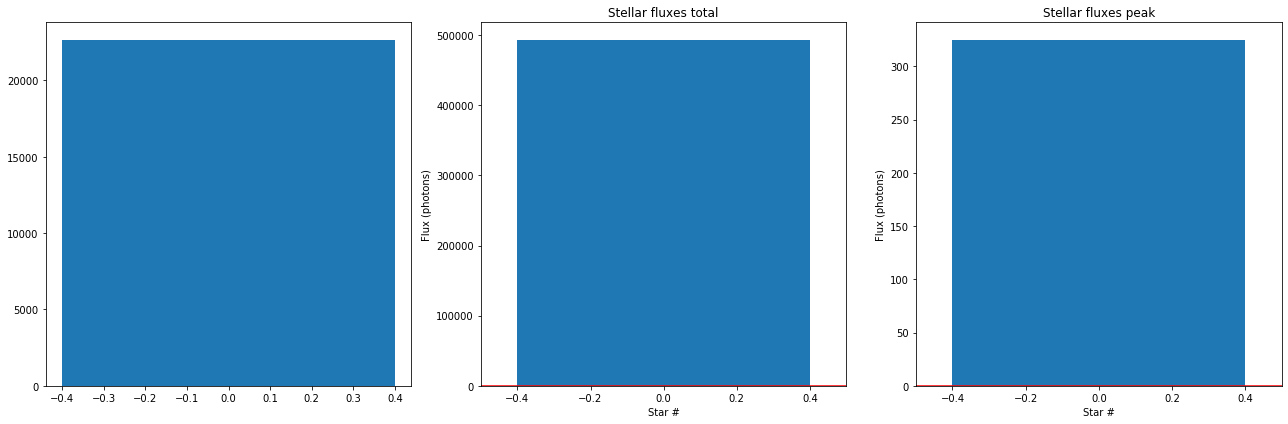

In [52]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.bar(range(n_stars), flux_found)

plt.subplot(1,3,2)
plt.title("Stellar fluxes total")
plt.bar(range(n_stars), fluxes)
plt.xlabel("Star #")
plt.ylabel("Flux (photons)")
plt.plot(range(-1, n_stars+1), mean*np.ones(n_stars+2), color='r')
plt.xlim(-.5, n_stars-.5)

plt.subplot(1,3,3)
plt.title("Stellar fluxes peak")
plt.bar(range(n_stars), fluxes*np.max(sub_PSF))
plt.xlabel("Star #")
plt.ylabel("Flux (photons)")
plt.plot(range(-1, n_stars+1), mean*np.ones(n_stars+2), color='r')
plt.xlim(-.5, n_stars-.5)

plt.tight_layout()
plt.show()

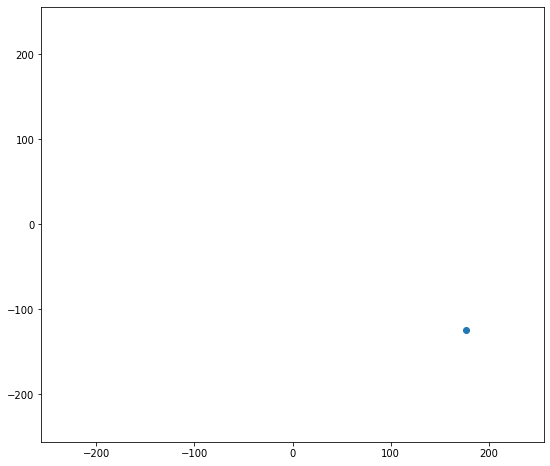

In [53]:
plt.figure(figsize=(9,8))
plt.scatter(pos_found[:,1], pos_found[:,0])
plt.xlim(-chip_dim//2, chip_dim//2)
plt.ylim(-chip_dim//2, chip_dim//2)
plt.show()
